# 6.6 Sourcing & Analysing Time-Series Data

### This script contains the following:

#### 01. Import Libraries
#### 02. Import Data
#### 03. Subsetting, wrangling, and cleaning time-series data
#### 04. Time series analysis: decomposition
#### 05. Testing for Stationarity
#### 06. Stationarising the Data

# 01. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.
warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.
plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# 02. Import Data

There were no relevant datasets on quandl, so I sourced my own. it features data from Newcastle United Football Club of the English Premier League, where I will be looking at attendance figures over time.

In [3]:
# Define path
path = r'C:\Users\tom\OneDrive\Documents\CareerFoundry - Data Analytics Course\Data Immersion\Tasks\Achievement 6\European Football Analysis'

In [4]:
# Import dataframe
df = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'NUFC 14-22 Complete Season Data.csv'))
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [5]:
df.head(100)

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,Attendance
0,2014-08-17,16:00,Premier League,Matchweek 1,Sun,Home,L,0,2,Manchester City,"50,816"
1,2014-08-23,12:45,Premier League,Matchweek 2,Sat,Away,D,0,0,Aston Villa,"30,267"
2,2014-08-26,19:45,League Cup,Second round,Tue,Away,W,1,0,Gillingham,"10,204"
3,2014-08-30,15:00,Premier League,Matchweek 3,Sat,Home,D,3,3,Crystal Palace,"49,226"
4,2014-09-13,15:00,Premier League,Matchweek 4,Sat,Away,L,0,4,Southampton,"29,678"
...,...,...,...,...,...,...,...,...,...,...,...
95,2016-09-28,19:45,Championship,Matchweek 10,Wed,Home,W,4,3,Norwich City,"48,236"
96,2016-10-01,15:00,Championship,Matchweek 11,Sat,Away,W,1,0,Rotherham Utd,"11,653"
97,2016-10-15,15:00,Championship,Matchweek 12,Sat,Home,W,3,1,Brentford,"51,885"
98,2016-10-18,19:45,Championship,Matchweek 13,Tue,Away,W,2,0,Barnsley,"18,597"


In [6]:
df.shape

(348, 11)

In [7]:
df.columns

Index(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'Attendance'],
      dtype='object')

In [8]:
type(df)

pandas.core.frame.DataFrame

# 03. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Check data types
df.dtypes

Date          datetime64[ns]
Time                  object
Comp                  object
Round                 object
Day                   object
Venue                 object
Result                object
GF                    object
GA                    object
Opponent              object
Attendance            object
dtype: object

In [10]:
# Change attendance to integer, removing ','s which stop this from working
df['Attendance'] = df['Attendance'].apply(lambda x: x.replace(',', '')).astype('int')

In [11]:
df.dtypes

Date          datetime64[ns]
Time                  object
Comp                  object
Round                 object
Day                   object
Venue                 object
Result                object
GF                    object
GA                    object
Opponent              object
Attendance             int32
dtype: object

In [12]:
# Drop away games from df - We're only interested in home attendances
df.drop(df[df['Venue'] == 'Away'].index, inplace = True)

In [13]:
# Drop attendance figures during Covid - they were restricted and do not represent true attendance figures
df.drop(df[df['Attendance'] <= 10000].index, inplace = True)

In [14]:
# Reset index so that you can use the "Date" column as a filter
df1 = df.reset_index()

In [15]:
df1.head()

,index,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,Attendance
0,0,2014-08-17,16:00,Premier League,Matchweek 1,Sun,Home,L,0,2,Manchester City,50816
1,3,2014-08-30,15:00,Premier League,Matchweek 3,Sat,Home,D,3,3,Crystal Palace,49226
2,5,2014-09-20,15:00,Premier League,Matchweek 5,Sat,Home,D,2,2,Hull City,49119
3,9,2014-10-18,16:00,Premier League,Matchweek 8,Sat,Home,W,1,0,Leicester City,51886
4,12,2014-11-01,12:45,Premier League,Matchweek 10,Sat,Home,W,1,0,Liverpool,52166


In [16]:
# Create subset for analysis
subset = df1[['Date', 'Attendance']]

I created a subset to use the core data I am interested in - Attendances and the dates they're from. I removed Covid years from the dataset as they are biased given the restrictions in place regarding attendances. I have also removed away games, as I specifically want to focus on attendances at one stadium to really understand the trends that occur here.

In [17]:
subset.shape

(147, 2)

In [18]:
subset.head()

,Date,Attendance
0,2014-08-17,50816
1,2014-08-30,49226
2,2014-09-20,49119
3,2014-10-18,51886
4,2014-11-01,52166


In [19]:
# Set the "Date" column as the index
from datetime import datetime

subset['datetime'] = pd.to_datetime(subset['Date'], format='%d-%m-%Y') # Create a datetime column from "Date".
subset = subset.set_index('datetime') # Set the datetime as the index of the dataframe.
subset.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
subset.head()

,Attendance
datetime,
2014-08-17,50816
2014-08-30,49226
2014-09-20,49119
2014-10-18,51886
2014-11-01,52166


In [20]:
subset.head()

,Attendance
datetime,
2014-08-17,50816
2014-08-30,49226
2014-09-20,49119
2014-10-18,51886
2014-11-01,52166


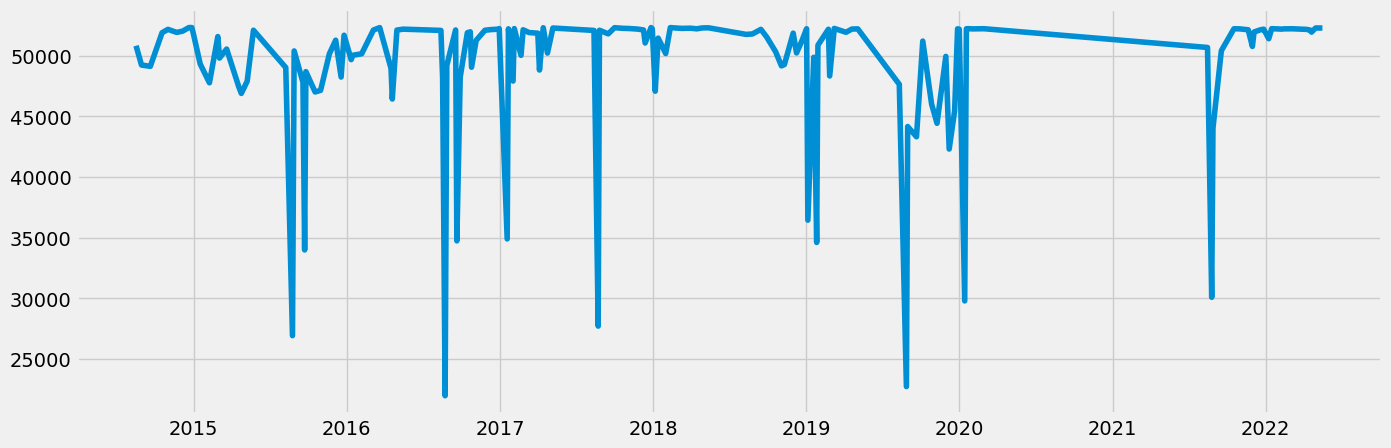

In [21]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(subset)

In [22]:
# Check for missing values (you shouldn't have any)
subset.isnull().sum() 

Attendance    0
dtype: int64

In [23]:
# Check for duplicates
dups = subset[subset.duplicated()]

In [43]:
# Check dups
dups

,Attendance
datetime,
2016-04-30,52107
2017-12-09,52117
2017-12-27,52311
2020-01-18,52217
2021-10-30,52208
2021-11-20,52131
2021-12-27,52178
2022-03-05,52214


These are not actually duplicates - It just happens that on 8 occasions the same attendance occured on different days. I do not needs to address this.

# 04. Time-series analysis: decomposition

In [25]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(subset, model='multiplicative', period=1)

In [26]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

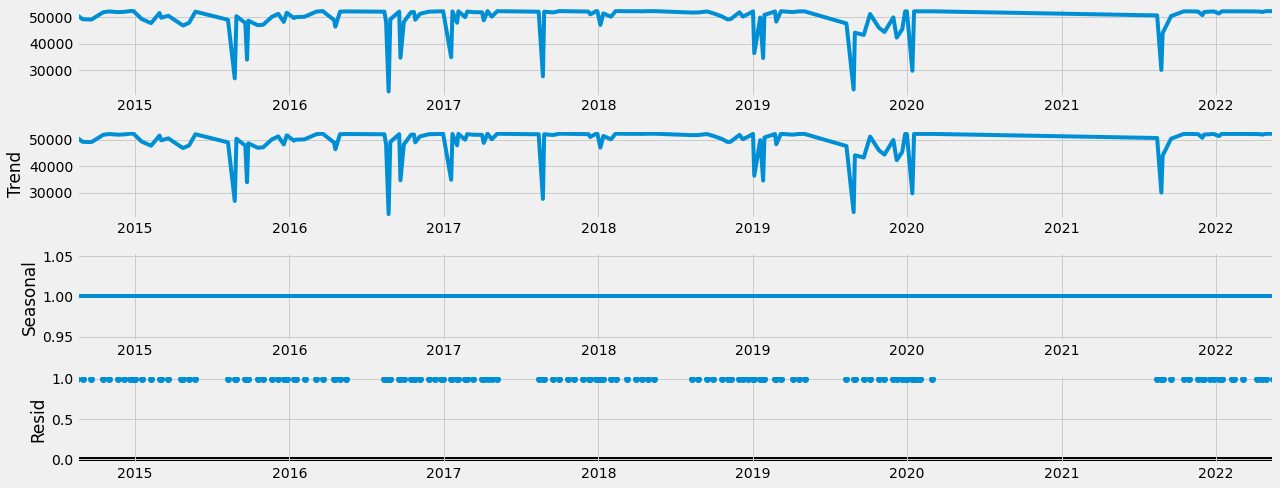

In [27]:
# Plot the separate components
decomposition.plot()
plt.show()

The decomposition shows that there is no seasonality in the data. This is logical, as the cycling seasons should not really impact the amount of people attending games. 
From the trends we can see the lower attendances caused by cup games, which are less interesting for people to attend. We can also see a general slump in the 2016/2017 period, caused by relegation to the championship.

The above also explains the noise shown from data fluctuations.

# 05. Testing for Stationarity

In [28]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(subset['Attendance'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.119761e+01
p-value                        2.285636e-20
Number of Lags Used            0.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


H0 = Presence of a unit root, Data Non-stationary.
HA = No unit root present, Data Stationary.

The test statistic of -1.119761e+01 is larger than the critical value (5%) of -2.881548e+00, meaning the null hypothesis cannot be rejected, although the p-value is less than 0.05. Stationarising of the data will be required.

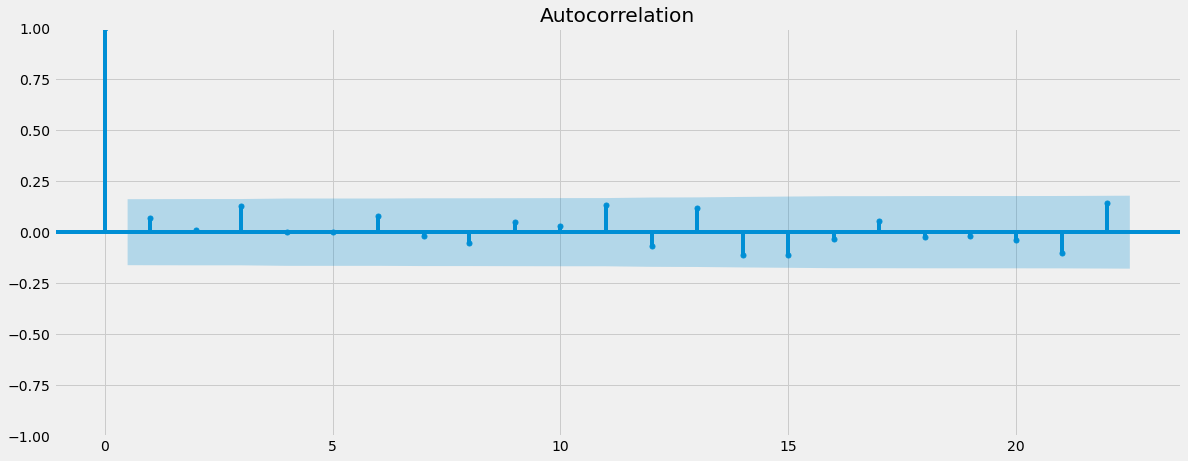

In [29]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(subset)
plt.show()

# 06. Stationarising the Data

In [30]:
data_diff = subset - subset.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [31]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [32]:
data_diff.head()

,Attendance
datetime,
2014-08-30,-1590.0
2014-09-20,-107.0
2014-10-18,2767.0
2014-11-01,280.0
2014-11-22,-251.0


In [33]:
data_diff.columns

Index(['Attendance'], dtype='object')

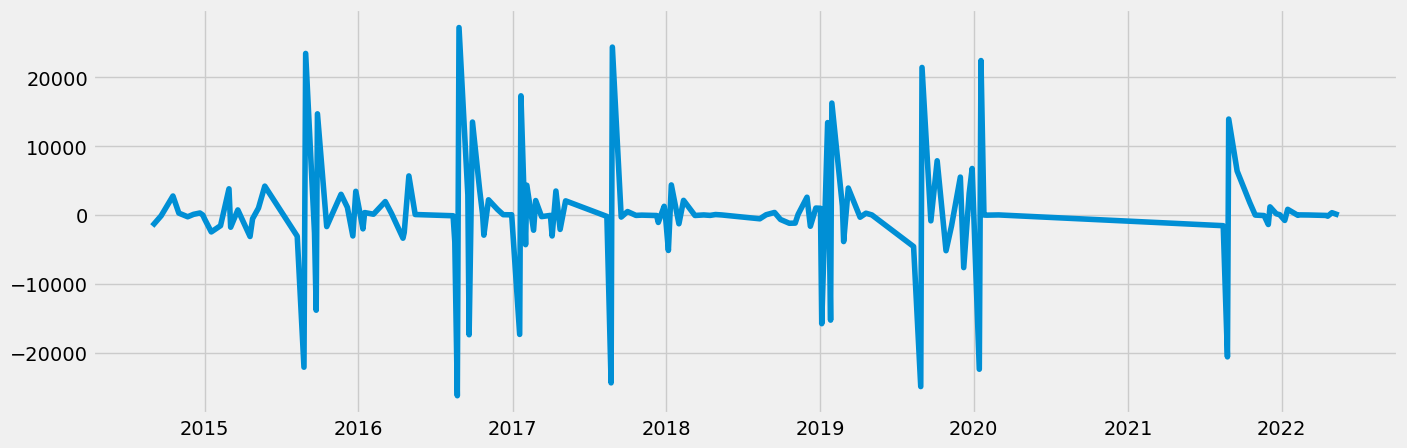

In [34]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.036747e+00
p-value                        1.376263e-07
Number of Lags Used            1.100000e+01
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


The test statistic of -6.036747e+00 is now smaller than the critical value (5%) of -2.883362e+00, meaing along with the p-value being less than 0.05, the null hypothesis can be rejected.

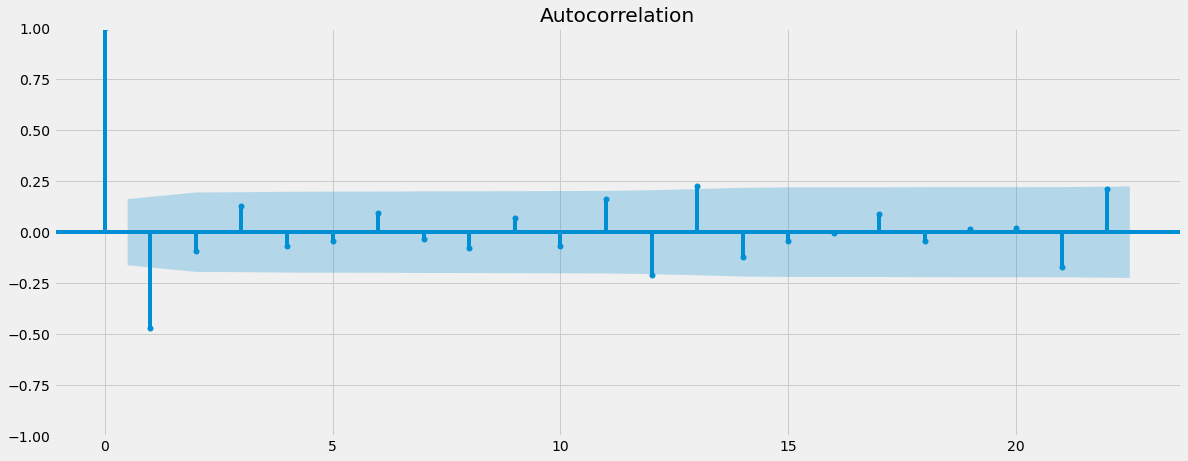

In [36]:
plot_acf(data_diff)
plt.show()